In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import math
from sklearn import svm
from sklearn.linear_model import LinearRegression
from operator import itemgetter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Data Content
This is for Channel 1-16, 186 trials
Load the mat file and show what we have to work with
Note that we primarily care about spectrogram, f(requency), t(ime), and y (labels)
Note that f and t are the values which frequency and time can take
Note that y is a 186x1 array

In [2]:
mat_contents = sio.loadmat('/home/joseph/Desktop/45516Channels.mat')

# Helper Functions

### splitSpectrogram
Parameters: size, spec_img  
"size" refers to the side of the square patch => we retrieve sizexsize patches  
"spec_img" refers to the individual spectrograms  
Returns the patches  

### getPatches
Parameters: size, data  
"size" refers to the square patch side length  
"data" refers to the trials from a specific Channel  
Returns the data in the form of iterable patches  

### shuffleData
Parameters: None  
Shuffles the data  
Returns the training and testing set of data and labels  

### genSpecAccMap
Parameters: accuracy, max_acc, min_acc  
"accuracy" refers to the accuracies of a specific model, across various runs of the model  
"max_acc" refers to the maximum accuracy for the models  
"min_acc" refers to the minimum accuracy for the models  

In [3]:
# Split a spectrogram according to patch size
def splitSpectrogram(size, spec_img):
    
    # Use num_width and num_height to refer to number of patches width/height
    patches = np.zeros((num_width, num_height, size, size))
    
    for i in range(num_width):
        # Get local patch in spectrogram
        wid_start_idx = i*5
        wid_end_idx = i*5 + 5
        
        # Stick to within the edges
        if (wid_end_idx > spec_img.shape[0]):
            wid_end_idx = spec_img.shape[0]
            wid_start_idx = spec_img.shape[0] - size
        for j in range(num_height):
            # Get local patch in spectrogram            
            len_start_idx = j*5
            len_end_idx = j*5 + 5
            
            # Stick to within the edges            
            if (len_end_idx > spec_img.shape[1]):
                len_end_idx = spec_img.shape[1]
                len_start_idx = spec_img.shape[1] - size
            patches[i,j] = spec_img[wid_start_idx:wid_end_idx, len_start_idx:len_end_idx]
            #print "Width indices: ", wid_start_idx, wid_end_idx
            #print "Length indices: ", len_start_idx, len_end_idx
            
    return patches

# Return patches of the spectrogram
def getPatches(size, data):
    # Generate Patches
    patches = []
    for i in range(num_examples):
        patches.append(splitSpectrogram(size, data[i]))

    # Convert to numpy array
    patches = np.asarray(patches)

    return  patches

# Randomly shuffle the data
def shuffleData():
    rem_test_indices = remembered_indices
    non_rem_test_indicies = non_remembered_indices


    np.random.shuffle(rem_test_indices)
    np.random.shuffle(non_rem_test_indicies)

    rem_test_indices = rem_test_indices[:num_test_rem]
    non_rem_test_indicies = non_remembered_indices[:num_test_nonrem]
    test_indices = np.concatenate((rem_test_indices,non_rem_test_indicies))
    
    # Data to return, in order
    label_train = []
    label_test = []
    data_train = []
    data_test = []
    
    for i in range(len(labels)):
        if (i not in test_indices):
            label_train.append(labels[i])
            data_train.append(patches[i])
        else:
            label_test.append(labels[i])
            data_test.append(patches[i])

    label_train = np.asarray(label_train)
    label_test = np.asarray(label_test)
    data_train = np.asarray(data_train)
    data_test = np.asarray(data_test)
    
    return label_train, label_test, data_train, data_test

# Reconstruct a map of the spectrogram, indicating relative predicting power
def genSpecAccMap(accuracy, max_acc, min_acc):
    
    # Retrieve mean accuracy
    mean_accuracy = np.zeros((num_width, num_height, 3))
    for i in range(num_width):
        for j in range(num_height):
            mean_accuracy[i,j] = np.mean(accuracy[:,i,j])
    
    # When width or length % patch_size != 0, average the last two patches
    width_overlap, height_overlap= False, False
    acc_width, acc_height = num_width, num_height
    if (spec_width % patch_size != 0):
        width_overlap = True
        acc_width -= 1
    if (spec_height % patch_size != 0):
        height_overlap = True
        acc_height -= 1
    
    # Return a RGB map of accuracies
    accuracy_map = np.zeros((spec_width, spec_height, 3))
    for i in range(acc_width):
        for j in range(acc_height):
            # Create accuracy if not edge and not overlap
            if (i != acc_width-1 or width_overlap != True) and (j != acc_height-1 or height_overlap != True):
                acc = (np.mean(accuracy[:,i,j]) - min_acc) / (max_acc-min_acc)
                wid_begin, wid_end = i*patch_size, i*patch_size+5
                len_begin, len_end = j*patch_size, j*patch_size+5
                accuracy_map[wid_begin:wid_end, len_begin:len_end] = [1-acc, acc, 0]
            else:
                # Modify i and j
                new_i, new_j = i, j
                wid_begin, wid_end = i*patch_size, i*patch_size+5
                len_begin, len_end = j*patch_size, j*patch_size+5                
                if (i == acc_width-1):
                    new_i += 1
                    wid_end += spec_width % patch_size
                if (j == acc_height-1):
                    new_j += 1
                    len_end += spec_height % patch_size
                    
                acc = (np.mean(accuracy[:,i,j]) + np.mean(accuracy[:,new_i,new_j]))/2
                acc = (acc - min_acc) / (max_acc-min_acc)
                accuracy_map[wid_begin:wid_end, len_begin:len_end] = [1-acc, acc, 0]
        
    return accuracy_map #, min_acc, max_acc

Machine Learning Functions

SVM, KNN, Linear Regression

In [4]:
def trainSVM(rbf=False):

    accuracy = np.zeros((num_width, num_height))
    pred = np.zeros((num_test, num_width, num_height))
    label_train, label_test, data_train, data_test = shuffleData()

    # Iterate over all patches
    for i in range(num_width):
        for j in range(num_height):
            # Set up specific kernel
            if (rbf):
                clf = svm.SVC(kernel='rbf')
            else:
                clf = svm.SVC()
                    
            # Train, predict, score accuracy
            clf.fit(data_train[:,i,j,:,:].reshape(num_train,-1),label_train[:])
            pred[:,i,j] = clf.predict(data_test[:,i,j,:,:].reshape(num_test,-1))
            correct = 0.
            for k in range(num_test):
                if pred[k,i,j] == label_test[k]:
                    correct += 1
            accuracy[i,j] = (correct/num_test)

    return pred, accuracy

def knn(k):
    if (k % num_classes == 0):
        print "K cannot be a multiple of the number of classes, changing k to: ", k+1
        k += 1
    
    # Want the nearest neighbor of 140 points for each testing data point's individual patches
    # 46 test images, 14 width, 32 length, 140 distances to compute
    # Last dim is 3: euclidean dist, labels of the training set, label of the test point
    distances = np.zeros((num_test, num_width, num_height, num_train, 3))
    distances = list(distances)
    
    # Retrieve a randomized selection of shuffled data points
    label_train, label_test, data_train, data_test = shuffleData()
    
    # Compare each patch location to the rest of the patch locations and calculate distances
    for test in range(num_test):
        for i in range(num_width):
            for j in range(num_height):
                for train in range(num_train):
                    test_lb = label_test[test]
                    train_lb = label_train[train]
                    test_pt = data_test[test][i][j].flatten()
                    train_pt = data_train[train][i][j].flatten()
                    distances[test][i][j][train] = ((np.linalg.norm(test_pt - train_pt), train_lb, test_lb))
    
    # Setup to find neighbors
    #sorted_distances = list(distances)
    for test in range(num_test):
        for i in range(num_width):
            for j in range(num_height):
                distances[test][i][j] = sorted(distances[test][i][j], key=itemgetter(0))
    pred = np.zeros((num_test, num_width, num_height))
    
    # Find neighbors
    for test in range(num_test):
        for i in range(num_width):
            for j in range(num_height):
                non_zero = 0
                for k_num in range(0,k):
                    if distances[test][i][j][k_num][1] == 1:
                        non_zero += 1

                # Make a prediction
                if non_zero > k/2.:
                    pred[test,i,j] = 1
                else:
                    pred[test,i,j] = 0
    
    # Calculate accuracies
    accuracy = np.zeros((num_width,num_height))
    for test in range(num_test):
        for i in range(num_width):
            for j in range(num_height):
                if (pred[test,i,j] == distances[test][i][j][0][2]):
                    accuracy[i,j] += 1.
    accuracy /= len(data_test)
    
    return pred, accuracy

def linReg():

    # Acquire the data
    label_train, label_test, data_train, data_test = shuffleData()
    data_train = data_train.reshape(num_train, num_width, num_height, patch_size**2)
    data_test = data_test.reshape(num_test, num_width, num_height, patch_size**2)

    acc = np.zeros((num_width, num_height))
    pred = np.zeros((num_test, num_width, num_height))

    # Iterate over patches, then over number of test samples
    for i in range(num_width):
        for j in range(num_height):
            lm = LinearRegression(fit_intercept=False, normalize=True)
            lm.fit(data_train[:,i,j],label_train)
            for test in range(num_test):
                pred[test,i,j] = lm.predict(data_test[test,i,j].reshape(1,-1))
    
    # Make predictions
    pred = np.rint(pred)
    
    for i in range(num_width):
        for j in range(num_height):
            for test in range(num_test):
                if pred[test,i,j] == label_test[test]:
                    acc[i,j] += 1
    
    acc /= len(label_test)
    
    return pred, acc

Run algorithms on 16 Channels for Patient 455

In [5]:
num_channels = mat_contents['spectrogram'].shape[0]
accuracy_map = np.zeros((num_channels, 4, 66, 157, 3))
# accuracy_min = np.zeros((num_channels, 4))
# accuracy_max = np.zeros((num_channels, 4))

for channel in range (num_channels):
    print "Running Channel ", channel
    
    # Data logistics
    data = mat_contents['spectrogram'][channel] # 186,1
    spec_width = data[0].shape[0] # 66
    spec_height = data[0].shape[1] # 157
    labels = mat_contents['y'].flatten() # 186,1
    num_examples = data.shape[0] # 186
    num_classes = len(np.unique(labels)) # 2

    # Remembered or not remembered
    remembered_indices = np.nonzero(labels)[0]
    num_remembered = np.count_nonzero(labels) # 80
    non_remembered_indices = filter(lambda x: x not in remembered_indices, range(num_examples))
    num_not_remembered = num_examples - num_remembered # 106

    # Patch size
    patch_size = 5
    num_width = int(math.ceil(float(spec_width)/patch_size)) # 14 patches across (5x5)
    num_height = int(math.ceil(float(spec_height)/patch_size)) # 32 patches down (5x5)
    
    # Split spectrogram into patches
    patches = getPatches(patch_size, data)

    # Train-test split
    train_split = 0.75
    test_split = 1 - train_split
    num_train = int(math.ceil(train_split*num_examples)) # 140
    num_test = num_examples - num_train # 46
    num_test_rem = int(test_split*num_remembered) # 20
    num_test_nonrem = num_test - num_test_rem # 26

    # Statistics
    num_iterations = 10 # Run model num_iteration times to reduce variance in results
    
    # Run SVM rbf and linear
    # Number of trials for svm
    svm_trials = 20

    # Predictions and accuracy (rbf)
    svm_pred_rbf = np.zeros((svm_trials, num_test, num_width, num_height))
    svm_accuracy_rbf = np.zeros((svm_trials, num_width, num_height))

    # Predictions and accuracy (linear)
    svm_pred = np.zeros((svm_trials, num_test, num_width, num_height))
    svm_accuracy = np.zeros((svm_trials, num_width, num_height))

    # With kernel = rbf
    #print "Running svm trials (rbf kernel)"
    for trial in range(svm_trials):
        svm_pred_rbf[trial], svm_accuracy_rbf[trial] = trainSVM(rbf=True)

    # With kernel = linear (default), not unable to run polynomial
    #print "Running svm trials (linear kernel)"
    for trial in range(svm_trials):
        svm_pred[trial], svm_accuracy[trial] = trainSVM()
                
    # KNN
    # Logisitics
    knn_trials = 20
    num_neighbors = 3

    # Predictions and accuracy
    knn_pred = np.zeros((knn_trials, num_test, num_width, num_height))
    knn_accuracy = np.zeros((knn_trials, num_width, num_height))

    # Run trials
    for knn_trial in range(knn_trials):
        knn_pred[knn_trial], knn_accuracy[knn_trial] = knn(num_neighbors)
                
    # Linear Regression
    # Logistics
    linreg_trials = 20

    # Predictions and accuracy
    linreg_pred = np.zeros((linreg_trials, num_test, num_width, num_height))
    linreg_accuracy = np.zeros((linreg_trials, num_width, num_height))

    # Run trials
    for trial in range(linreg_trials):
        linreg_pred[trial], linreg_accuracy[trial] = linReg()
        
    global_max_acc = np.max([svm_accuracy_rbf, svm_accuracy, knn_accuracy, linreg_accuracy])
    global_min_acc = np.min([svm_accuracy_rbf, svm_accuracy, knn_accuracy, linreg_accuracy])
                
    # Accuracy map for svm rbf
#     accuracy_map[channel, 0], accuracy_min[channel, 0], accuracy_max[channel, 0] = genSpecAccMap(svm_accuracy_rbf)
    
#     # Accuracy map for svm
#     accuracy_map[channel, 1], accuracy_min[channel, 1], accuracy_max[channel, 1] = genSpecAccMap(svm_accuracy)
    
#     # Accuracy map for knn
#     accuracy_map[channel, 2], accuracy_min[channel, 2], accuracy_max[channel, 2] = genSpecAccMap(knn_accuracy)
    
#     # Accuracy map for linear regression
#     accuracy_map[channel, 3], accuracy_min[channel, 3], accuracy_max[channel, 3] = genSpecAccMap(linreg_accuracy)
    
    # Accuracy map for svm rbf
    accuracy_map[channel, 0] = genSpecAccMap(svm_accuracy_rbf, global_max_acc, global_min_acc)
    
    # Accuracy map for svm
    accuracy_map[channel, 1] = genSpecAccMap(svm_accuracy, global_max_acc, global_min_acc)
    
    # Accuracy map for knn
    accuracy_map[channel, 2] = genSpecAccMap(knn_accuracy, global_max_acc, global_min_acc)
    
    # Accuracy map for linear regression
    accuracy_map[channel, 3] = genSpecAccMap(linreg_accuracy, global_max_acc, global_min_acc)

Running Channel  0
Running Channel  1
Running Channel  2
Running Channel  3
Running Channel  4
Running Channel  5
Running Channel  6
Running Channel  7
Running Channel  8
Running Channel  9
Running Channel  10
Running Channel  11
Running Channel  12
Running Channel  13
Running Channel  14
Running Channel  15


/usr/lib/pymodules/python2.7/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


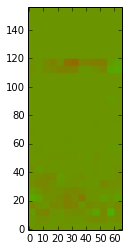

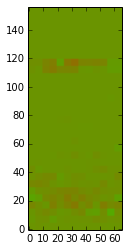

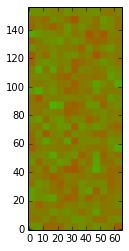

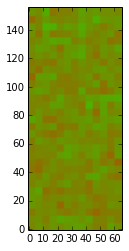

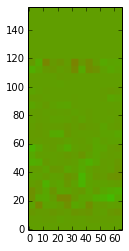

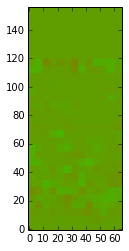

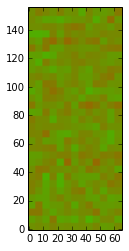

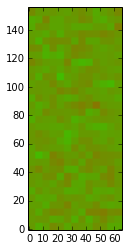

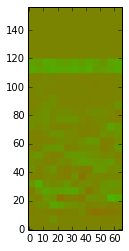

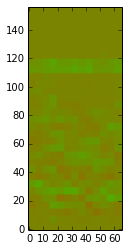

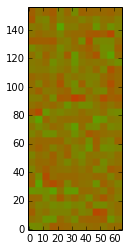

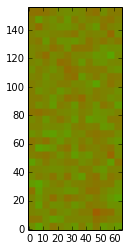

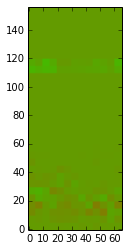

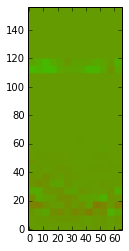

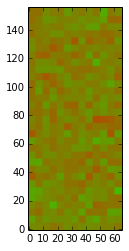

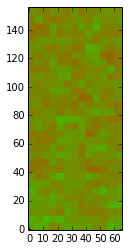

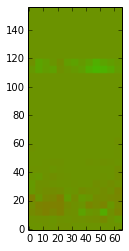

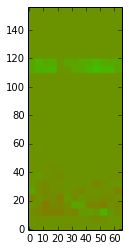

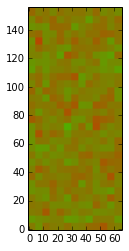

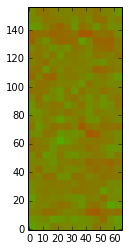

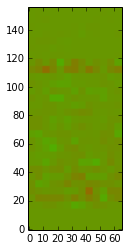

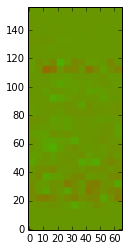

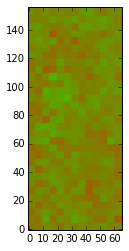

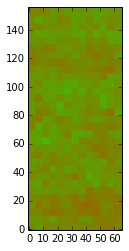

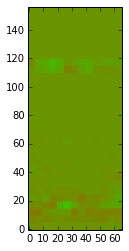

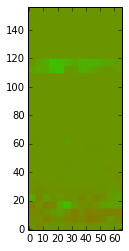

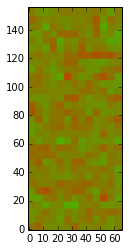

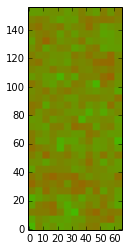

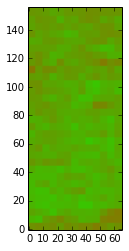

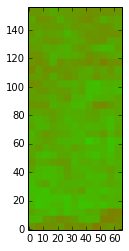

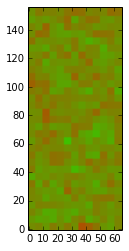

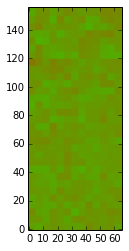

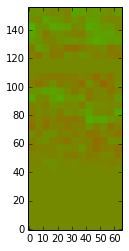

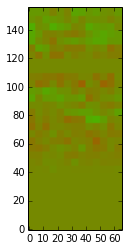

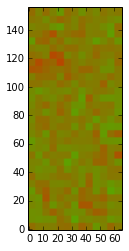

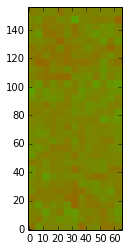

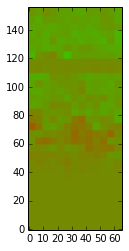

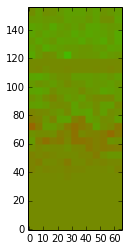

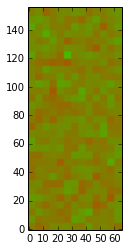

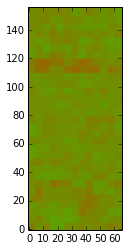

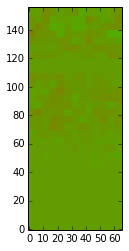

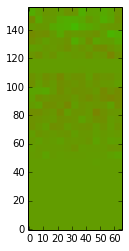

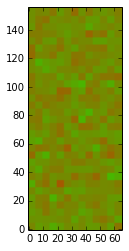

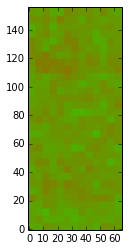

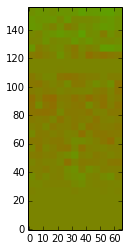

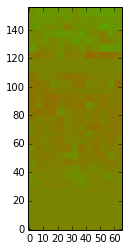

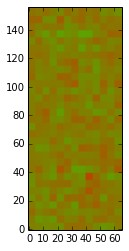

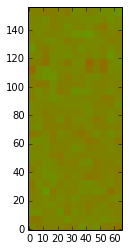

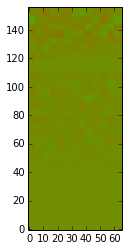

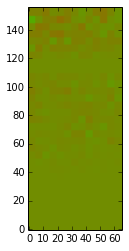

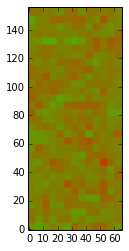

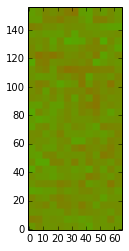

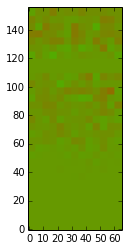

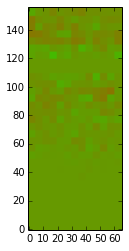

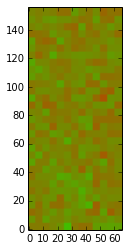

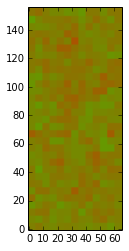

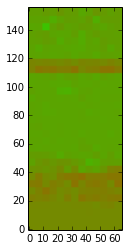

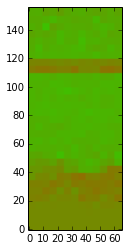

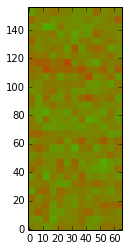

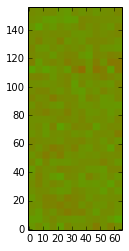

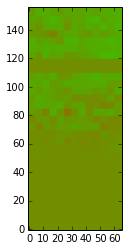

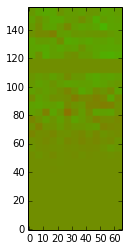

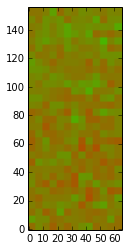

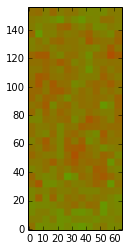

In [6]:
for i in range(num_channels):
    for j in range(4):
        plt.figure()
        plt.imshow(accuracy_map[i,j].transpose(1,0,2))
        plt.gca().invert_yaxis()

In [7]:
print knn_accuracy.shape
print linreg_accuracy.shape
print svm_accuracy.shape
print svm_accuracy_rbf.shape
print np.max([knn_accuracy, linreg_accuracy, svm_accuracy])

(20, 14, 32)
(20, 14, 32)
(20, 14, 32)
(20, 14, 32)
0.804347826087


In [8]:
print global_max_acc, global_min_acc

0.804347826087 0.260869565217
